In [1]:
#%%

from array import array
from cmath import nan
from pyexpat import model
import statistics
import numpy as np  
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#%%
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_train_gene.csv', delimiter = ',')
# train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_train_hml.csv')
# train_target = train_target[['EMB_MIC']]
# # don't touch test data, split out validation data from training data during training
# # test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_EMB/aa_data_test_pca4k.csv', delimiter = ',')
# test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_test_gene.csv', delimiter = ',')
# test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_test_hml.csv')
# test_target = test_target[['EMB_MIC']]

# all_data = np.concatenate((train_data, test_data), axis=0)
# all_target = pd.concat((train_target, test_target), axis=0)

# train_data, test_data, train_target, test_target = train_test_split(all_data, all_target, test_size=0.2, random_state=42, stratify=all_target)

In [2]:

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')
    
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
      in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

In [3]:
clinical_lung = pd.read_csv('/mnt/storageG1/lwang/Projects/TBpt/Analysis/clinical_lung17102024.csv')
clinical_lung.drop(columns=['condition_id'], inplace=True)

country_mapping = {
    'China': 1,        # High medical capacity, large infrastructure, advanced technology
    'India': 2,        # Large infrastructure, but strained capacity due to population
    'South Africa': 3, # Developed healthcare, but regional disparities
    'Romania': 4,      # Developing EU healthcare standards
    'Ukraine': 5,      # Moderate capacity but strained due to recent conflicts
    'Belarus': 6,      # Moderate capacity, state-funded healthcare
    'Kazakhstan': 7,   # Developing healthcare system
    'Azerbaijan': 8,   # Developing healthcare system
    'Georgia': 9,      # Smaller healthcare capacity, improving
    'Moldova': 10,     # Limited resources, developing healthcare
    'Kyrgyzstan': 11,  # Limited resources, developing healthcare
    'Nigeria': 12,     # Limited healthcare capacity, large population challenges
    'Senegal': 13      # Developing healthcare system with limited resources
}

# Apply the mapping to the 'country' column
clinical_lung['country'] = clinical_lung['country'].replace(country_mapping).fillna(0)

/tmp/ipykernel_27713/398589087.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clinical_lung['country'] = clinical_lung['country'].replace(country_mapping).fillna(0)


In [4]:
clinical_lung_features = clinical_lung[[ 'overall_percent_of_abnormal_volume',
       'pleural_effusion_percent_of_hemithorax_involved',
       'ispleuraleffusionbilateral', 'other_non_tb_abnormalities',
       'are_mediastinal_lymphnodes_present', 'collapse', 'smallcavities',
       'mediumcavities', 'largecavities',
       'isanylargecavitybelongtoamultisextantcavity',
       'canmultiplecavitiesbeseen', 'infiltrate_lowgroundglassdensity',
       'infiltrate_mediumdensity', 'infiltrate_highdensity', 'smallnodules',
       'mediumnodules', 'largenodules', 'hugenodules',
       'isanycalcifiedorpartiallycalcifiednoduleexist',
       'isanynoncalcifiednoduleexist', 'isanyclusterednoduleexists',
       'aremultiplenoduleexists', 'lowgroundglassdensityactivefreshnodules',
       'mediumdensitystabalizedfibroticnodules',
       'highdensitycalcifiedtypicallysequella', 'timika_score',
       'education', 'gender', 'employment', 'type_of_resistance',
       'number_of_daily_contacts', 'bmi', 'lung_localization', 'totalcavernum',
       'case_definition', 'diagnosis_code', 'comorbidity',
       'social_risk_factors']]#'condition_id','country'

clinical_lung_labels = clinical_lung[['outcome']]

In [5]:
from sklearn.neighbors import kneighbors_graph
import numpy as np

# Example data: each row is a sample, each column is a feature

# Generate a k-nearest neighbors graph, specifying the number of neighbors
n_neighbors = 5
knn_graph = kneighbors_graph(clinical_lung_features, n_neighbors=n_neighbors, mode='connectivity', include_self=False)

# Convert the sparse matrix to dense format if needed
dense_matrix = knn_graph.toarray()

row_indices, col_indices = np.nonzero(dense_matrix)

# Stack these indices to create an edge index (2 x num_edges)
edge_index = np.stack([row_indices, col_indices], axis=0)

# Convert edge_index to a PyTorch tensor (if you're using PyTorch Geometric)
edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)

# Now edge_index_tensor is in the format that a GCN can use: (2 x num_edges)
print(edge_index_tensor)
# Check the unique values in the generated matrix
# unique_values = np.unique(dense_matrix)
# print("Unique values:", unique_values)
# adjacency_matrix = dense_matrix

tensor([[    0,     0,     0,  ..., 10149, 10149, 10149],
        [ 1591,  2236,  5701,  ...,  1811,  5927,  6150]])


In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Assume clinical_lung_features is your input DataFrame and adjacency_matrix is your edge matrix
features = clinical_lung_features.values  # shape (10150, 38)

adjacency_matrix = adjacency_matrix  # shape (10150, 10150)

# Assume y is your labels column in the dataframe
y = clinical_lung_labels  # Replace this with your actual labels (shape: 10150,)

# Step 1: Perform stratified split into train+val and test sets
train_val_indices, test_indices = train_test_split(
    np.arange(features.shape[0]),
    test_size=0.2,
    random_state=42,
    stratify=y  # Ensure that the split is stratified based on the labels
)

# Step 2: Further split the train+val set into separate training and validation sets
train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=0.25,  # 25% of train+val becomes the validation set, so 0.25 * 0.8 = 0.2 of the total data
    random_state=42,
    stratify=y.iloc[train_val_indices]  # Stratify based on the labels in the train+val set
)

# Separate features and labels based on the indices
train_features = torch.tensor(features[train_indices], dtype=torch.float32)
val_features = torch.tensor(features[val_indices], dtype=torch.float32)
test_features = torch.tensor(features[test_indices], dtype=torch.float32)

train_labels = torch.tensor(y.iloc[train_indices].values, dtype=torch.long)
val_labels = torch.tensor(y.iloc[val_indices].values, dtype=torch.long)
test_labels = torch.tensor(y.iloc[test_indices].values, dtype=torch.long)

# Train adjacency matrix (rows and columns of the train_indices)
train_adj_matrix = adjacency_matrix[np.ix_(train_indices, train_indices)]

# Validation adjacency matrix (rows and columns of the val_indices)
val_adj_matrix = adjacency_matrix[np.ix_(val_indices, val_indices)]

# Test adjacency matrix (rows and columns of the test_indices)
test_adj_matrix = adjacency_matrix[np.ix_(test_indices, test_indices)]  

NameError: name 'adjacency_matrix' is not defined

In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Assume clinical_lung_features is your input DataFrame and adjacency_matrix is your edge matrix
features = clinical_lung_features.values  # shape (10150, 38)
adjacency_matrix = adjacency_matrix  # shape (10150, 10150)
y = clinical_lung_labels  # Replace this with your actual labels (shape: 10150,)

# Step 1: Perform stratified split into train+val and test sets
train_val_indices, test_indices = train_test_split(
    np.arange(features.shape[0]),
    test_size=0.2,
    random_state=42,
    stratify=y  # Ensure that the split is stratified based on the labels
)

# Step 2: Further split the train+val set into separate training and validation sets
train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=0.25,  # 25% of train+val becomes the validation set, so 0.25 * 0.8 = 0.2 of the total data
    random_state=42,
    stratify=y.iloc[train_val_indices]  # Stratify based on the labels in the train+val set
)

# Separate features and labels based on the indices
train_features = features[train_indices]
val_features = features[val_indices]
test_features = features[test_indices]

train_labels = y.iloc[train_indices].values
val_labels = y.iloc[val_indices].values
test_labels = y.iloc[test_indices].values

# Combine features and labels to identify duplicates
train_data = pd.DataFrame(train_features)
train_data['label'] = train_labels
train_data = train_data.drop_duplicates().reset_index(drop=True)
train_features = train_data.iloc[:, :-1].values
train_labels = train_data['label'].values

val_data = pd.DataFrame(val_features)
val_data['label'] = val_labels
val_data = val_data.drop_duplicates().reset_index(drop=True)
val_features = val_data.iloc[:, :-1].values
val_labels = val_data['label'].values

test_data = pd.DataFrame(test_features)
test_data['label'] = test_labels
test_data = test_data.drop_duplicates().reset_index(drop=True)
test_features = test_data.iloc[:, :-1].values
test_labels = test_data['label'].values

# Convert features and labels back to tensors
train_features = torch.tensor(train_features, dtype=torch.float32)
val_features = torch.tensor(val_features, dtype=torch.float32)
test_features = torch.tensor(test_features, dtype=torch.float32)

train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Create adjacency matrices using updated indices
train_indices = train_data.index.values
val_indices = val_data.index.values
test_indices = test_data.index.values

train_adj_matrix = adjacency_matrix[np.ix_(train_indices, train_indices)]
val_adj_matrix = adjacency_matrix[np.ix_(val_indices, val_indices)]
test_adj_matrix = adjacency_matrix[np.ix_(test_indices, test_indices)]


In [104]:

# Step 2: Create the edge_index for both training and testing
# You could keep the same adjacency matrix for both if the graph structure is the same.
def adjacency_to_edge_index(adj_matrix):
    edge_index = np.array(np.nonzero(adj_matrix))  # Get the non-zero indices of the adjacency matrix
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = adjacency_to_edge_index(adjacency_matrix)
edge_index_train = adjacency_to_edge_index(train_adj_matrix)
edge_index_val = adjacency_to_edge_index(val_adj_matrix )
edge_index_test = adjacency_to_edge_index(test_adj_matrix)

# Step 3: Create PyTorch Geometric Data objects if you're using graph data
train_data = Data(x=train_features, edge_index=torch.tensor(edge_index_train), y=train_labels)
val_data = Data(x=val_features, edge_index=torch.tensor(edge_index_val), y=val_labels)
test_data = Data(x=test_features, edge_index=torch.tensor(edge_index_test), y=test_labels)

# Step 4: Create DataLoaders
batch_size = 64
train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
val_loader = DataLoader([val_data], batch_size=batch_size, shuffle=False)
test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)


# GCN Model (same as before)
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # First GCN layer with ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Second GCN layer
        x = self.conv2(x, edge_index)
        # return F.log_softmax(x, dim=1)
        return x

# Instantiate the model, optimizer, and loss function
input_dim = train_features.shape[1]  # 38 features in the input
hidden_dim = 64  # Arbitrary hidden layer size
output_dim = 2  # Number of output classes, adjust this based on your problem

model = GCN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

/tmp/ipykernel_19272/1379182576.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = Data(x=train_features, edge_index=torch.tensor(edge_index_train), y=train_labels)
/tmp/ipykernel_19272/1379182576.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_data = Data(x=val_features, edge_index=torch.tensor(edge_index_val), y=val_labels)
/tmp/ipykernel_19272/1379182576.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = Data(x=test_features, edge_index=torch.tensor(edge_index_test), y=test_labels)
/mnt/storageG1/l

In [113]:
import torch
import torch.nn.functional as F

# Define the training function
def train(model, optimizer, criterion, train_loader):
    model.train()  # Set the model to training mode
    total_loss = 0  # Track total loss for the epoch
    
    for batch in train_loader:
        optimizer.zero_grad()  # Reset gradients
        out = model(batch)  # Forward pass
        batch_y = batch.y.squeeze()
        loss = criterion(out, batch_y)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        total_loss += loss.item()  # Accumulate the batch loss
    
    avg_loss = total_loss / len(train_loader)  # Average loss for the epoch
    # print(f'Training Loss: {avg_loss:.4f}')
    
    return avg_loss

# Define the validation function
def validate(model, criterion, val_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for validation
        for batch in val_loader:
            out = model(batch)  # Forward pass
            batch_y = batch.y.squeeze()
            loss = criterion(out, batch_y)  # Compute loss
            total_loss += loss.item()  # Accumulate the batch loss
            
            pred = out.argmax(dim=1)  # Get predictions
            correct += (pred == batch.y).sum().item()  # Count correct predictions
            
            all_preds.extend(pred.cpu().numpy())  # Store predictions
            all_labels.extend(batch.y.cpu().numpy())  # Store true labels

    accuracy = correct / len(val_loader.dataset)  # Compute accuracy
    avg_loss = total_loss / len(val_loader)  # Average loss for the epoch
    # print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')
    
    return avg_loss, accuracy


from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for batch in test_loader:
            out = model(batch)  # Forward pass
            pred = out.argmax(dim=1)  # Get the predicted class (highest score)
            all_preds.extend(pred.cpu().numpy())  # Store predictions
            all_labels.extend(batch.y.cpu().numpy())  # Store true labels

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    sensitivity = recall_score(all_labels, all_preds)  # Same as recall
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    
    # Output results
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    print(f'Sensitivity (Recall): {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    
    return accuracy, sensitivity, specificity, conf_matrix

# Combine training and validation in the epoch loop
def train_and_validate(model, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs=100):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in tqdm(range(num_epochs)):
        # print(f'Epoch {epoch + 1}/{num_epochs}')
        
        # Training step
        train_loss = train(model, optimizer, criterion, train_loader)
        
        # Validation step
        val_loss, val_accuracy = validate(model, criterion, val_loader)

        # Store losses and accuracy
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        if epoch % 20 == 0:
            print(f'Epoch {epoch + 1} completed. Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%\n')

    # Plotting the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    test(model, test_loader)
    # Optionally, you can also plot validation accuracy
    # plt.figure(figsize=(10, 5))
    # plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
    # plt.xlabel('Epochs')
    # plt.ylabel('Accuracy')
    # plt.title('Validation Accuracy')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

testing variables 0.001


  1%|          | 2/200 [00:00<00:10, 19.12it/s]

Epoch 1 completed. Train Loss: 1.4857, Val Loss: 0.9757, Val Accuracy: 232181000.00%



 13%|█▎        | 26/200 [00:00<00:04, 42.02it/s]

Epoch 21 completed. Train Loss: 0.6257, Val Loss: 0.6135, Val Accuracy: 290019000.00%



 23%|██▎       | 46/200 [00:01<00:03, 43.96it/s]

Epoch 41 completed. Train Loss: 0.5380, Val Loss: 0.5531, Val Accuracy: 312404000.00%



 33%|███▎      | 66/200 [00:01<00:02, 45.13it/s]

Epoch 61 completed. Train Loss: 0.4995, Val Loss: 0.5163, Val Accuracy: 305870000.00%



 43%|████▎     | 86/200 [00:01<00:02, 45.22it/s]

Epoch 81 completed. Train Loss: 0.4803, Val Loss: 0.4953, Val Accuracy: 309258000.00%



 53%|█████▎    | 106/200 [00:02<00:02, 45.68it/s]

Epoch 101 completed. Train Loss: 0.4678, Val Loss: 0.4833, Val Accuracy: 309137000.00%



 63%|██████▎   | 126/200 [00:02<00:01, 44.55it/s]

Epoch 121 completed. Train Loss: 0.4594, Val Loss: 0.4738, Val Accuracy: 308895000.00%



 73%|███████▎  | 146/200 [00:03<00:01, 44.85it/s]

Epoch 141 completed. Train Loss: 0.4532, Val Loss: 0.4666, Val Accuracy: 309258000.00%



 83%|████████▎ | 166/200 [00:03<00:00, 45.33it/s]

Epoch 161 completed. Train Loss: 0.4485, Val Loss: 0.4612, Val Accuracy: 308895000.00%



 93%|█████████▎| 186/200 [00:04<00:00, 45.87it/s]

Epoch 181 completed. Train Loss: 0.4448, Val Loss: 0.4573, Val Accuracy: 309016000.00%



100%|██████████| 200/200 [00:04<00:00, 44.41it/s]


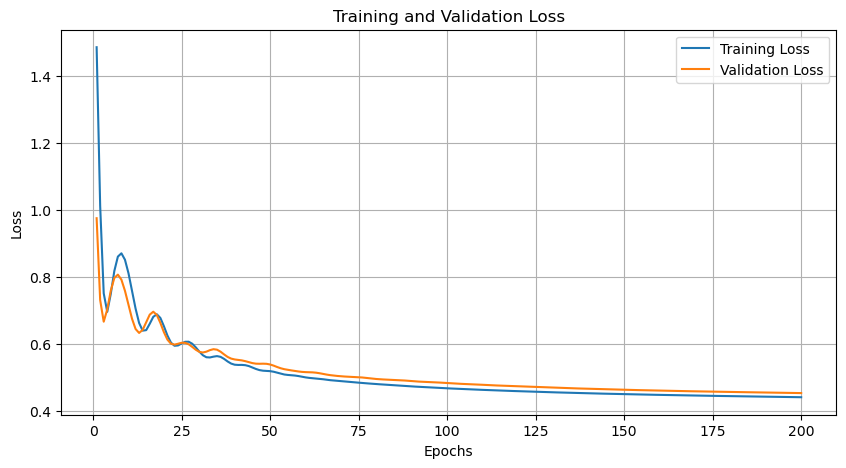

Test Accuracy: 80.15%
Sensitivity (Recall): 0.9475
Specificity: 0.2244
Confusion Matrix:
[[  92  318]
 [  85 1535]]
testing variables 0.0001


  2%|▎         | 5/200 [00:00<00:04, 48.03it/s]

Epoch 1 completed. Train Loss: 1.2343, Val Loss: 1.1450, Val Accuracy: 299941000.00%



 14%|█▎        | 27/200 [00:00<00:03, 52.25it/s]

Epoch 21 completed. Train Loss: 1.0603, Val Loss: 0.9952, Val Accuracy: 302361000.00%



 26%|██▌       | 51/200 [00:01<00:02, 50.41it/s]

Epoch 41 completed. Train Loss: 0.9242, Val Loss: 0.8784, Val Accuracy: 305386000.00%



 34%|███▎      | 67/200 [00:01<00:02, 48.69it/s]

Epoch 61 completed. Train Loss: 0.8206, Val Loss: 0.7875, Val Accuracy: 309984000.00%



 44%|████▎     | 87/200 [00:01<00:02, 48.37it/s]

Epoch 81 completed. Train Loss: 0.7403, Val Loss: 0.7144, Val Accuracy: 311436000.00%



 54%|█████▎    | 107/200 [00:02<00:01, 48.23it/s]

Epoch 101 completed. Train Loss: 0.6778, Val Loss: 0.6563, Val Accuracy: 312041000.00%



 64%|██████▎   | 127/200 [00:02<00:01, 48.00it/s]

Epoch 121 completed. Train Loss: 0.6286, Val Loss: 0.6104, Val Accuracy: 313130000.00%



 74%|███████▎  | 147/200 [00:03<00:01, 48.06it/s]

Epoch 141 completed. Train Loss: 0.5897, Val Loss: 0.5745, Val Accuracy: 312646000.00%



 84%|████████▎ | 167/200 [00:03<00:00, 46.01it/s]

Epoch 161 completed. Train Loss: 0.5591, Val Loss: 0.5467, Val Accuracy: 312283000.00%



 95%|█████████▌| 190/200 [00:03<00:00, 49.25it/s]

Epoch 181 completed. Train Loss: 0.5354, Val Loss: 0.5252, Val Accuracy: 311799000.00%



100%|██████████| 200/200 [00:04<00:00, 48.12it/s]


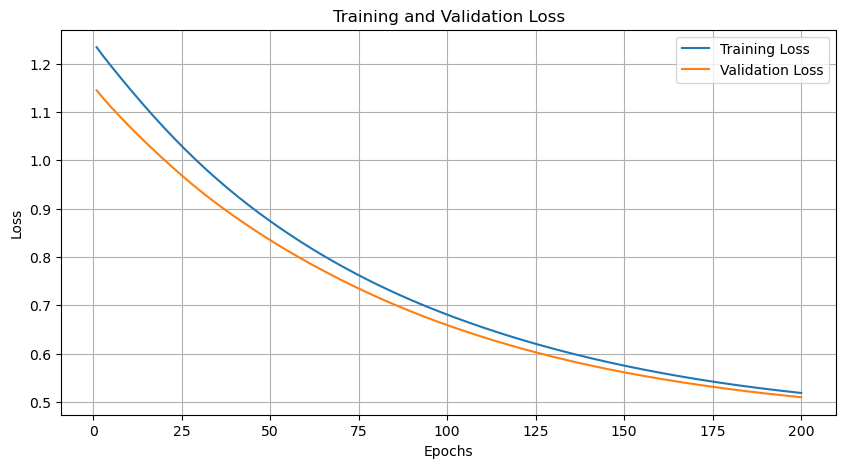

Test Accuracy: 78.72%
Sensitivity (Recall): 0.9469
Specificity: 0.1561
Confusion Matrix:
[[  64  346]
 [  86 1534]]
testing variables 1e-05


  2%|▎         | 5/200 [00:00<00:04, 48.69it/s]

Epoch 1 completed. Train Loss: 5.9258, Val Loss: 5.3904, Val Accuracy: 84319000.00%



 13%|█▎        | 26/200 [00:00<00:03, 49.85it/s]

Epoch 21 completed. Train Loss: 5.7048, Val Loss: 5.1952, Val Accuracy: 85650000.00%



 23%|██▎       | 46/200 [00:00<00:03, 45.70it/s]

Epoch 41 completed. Train Loss: 5.4857, Val Loss: 5.0017, Val Accuracy: 87102000.00%



 33%|███▎      | 66/200 [00:01<00:02, 45.65it/s]

Epoch 61 completed. Train Loss: 5.2689, Val Loss: 4.8102, Val Accuracy: 88312000.00%



 43%|████▎     | 86/200 [00:01<00:02, 44.43it/s]

Epoch 81 completed. Train Loss: 5.0547, Val Loss: 4.6211, Val Accuracy: 89885000.00%



 53%|█████▎    | 106/200 [00:02<00:02, 45.55it/s]

Epoch 101 completed. Train Loss: 4.8433, Val Loss: 4.4345, Val Accuracy: 91821000.00%



 63%|██████▎   | 126/200 [00:02<00:01, 46.70it/s]

Epoch 121 completed. Train Loss: 4.6350, Val Loss: 4.2507, Val Accuracy: 94120000.00%



 73%|███████▎  | 146/200 [00:03<00:01, 46.98it/s]

Epoch 141 completed. Train Loss: 4.4302, Val Loss: 4.0699, Val Accuracy: 96419000.00%



 83%|████████▎ | 166/200 [00:03<00:00, 48.67it/s]

Epoch 161 completed. Train Loss: 4.2289, Val Loss: 3.8923, Val Accuracy: 98960000.00%



 93%|█████████▎| 186/200 [00:03<00:00, 48.31it/s]

Epoch 181 completed. Train Loss: 4.0316, Val Loss: 3.7181, Val Accuracy: 102832000.00%



100%|██████████| 200/200 [00:04<00:00, 46.94it/s]


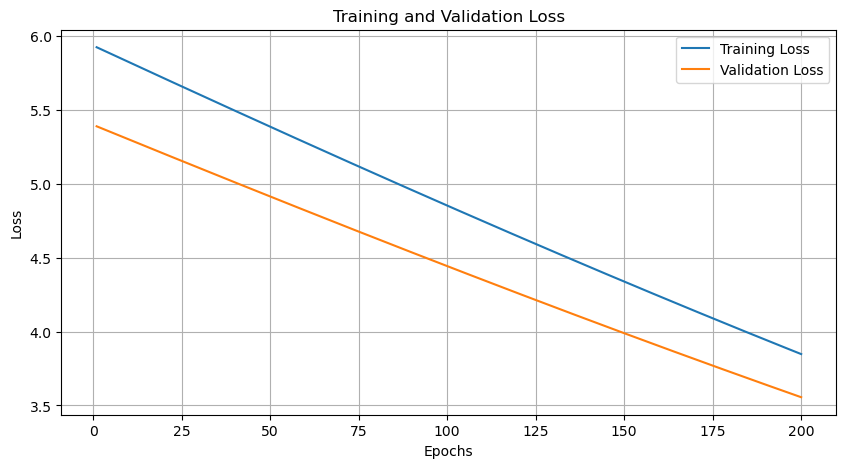

Test Accuracy: 25.52%
Sensitivity (Recall): 0.1031
Specificity: 0.8561
Confusion Matrix:
[[ 351   59]
 [1453  167]]
testing variables 1e-06


  2%|▎         | 5/200 [00:00<00:04, 44.13it/s]

Epoch 1 completed. Train Loss: 3.4258, Val Loss: 3.2356, Val Accuracy: 187169000.00%



 14%|█▍        | 29/200 [00:00<00:03, 54.14it/s]

Epoch 21 completed. Train Loss: 3.4188, Val Loss: 3.2293, Val Accuracy: 187169000.00%



 24%|██▎       | 47/200 [00:00<00:02, 54.73it/s]

Epoch 41 completed. Train Loss: 3.4118, Val Loss: 3.2229, Val Accuracy: 187169000.00%



 32%|███▎      | 65/200 [00:01<00:02, 53.09it/s]

Epoch 61 completed. Train Loss: 3.4049, Val Loss: 3.2165, Val Accuracy: 187411000.00%



 44%|████▍     | 89/200 [00:01<00:02, 48.76it/s]

Epoch 81 completed. Train Loss: 3.3979, Val Loss: 3.2102, Val Accuracy: 187411000.00%



 54%|█████▎    | 107/200 [00:02<00:01, 49.95it/s]

Epoch 101 completed. Train Loss: 3.3910, Val Loss: 3.2038, Val Accuracy: 187411000.00%



 64%|██████▍   | 128/200 [00:02<00:01, 48.38it/s]

Epoch 121 completed. Train Loss: 3.3841, Val Loss: 3.1974, Val Accuracy: 187653000.00%



 74%|███████▍  | 148/200 [00:02<00:01, 46.55it/s]

Epoch 141 completed. Train Loss: 3.3771, Val Loss: 3.1911, Val Accuracy: 187653000.00%



 84%|████████▍ | 168/200 [00:03<00:00, 47.61it/s]

Epoch 161 completed. Train Loss: 3.3702, Val Loss: 3.1848, Val Accuracy: 187653000.00%



 94%|█████████▍| 188/200 [00:03<00:00, 49.07it/s]

Epoch 181 completed. Train Loss: 3.3633, Val Loss: 3.1784, Val Accuracy: 187653000.00%



100%|██████████| 200/200 [00:04<00:00, 49.27it/s]


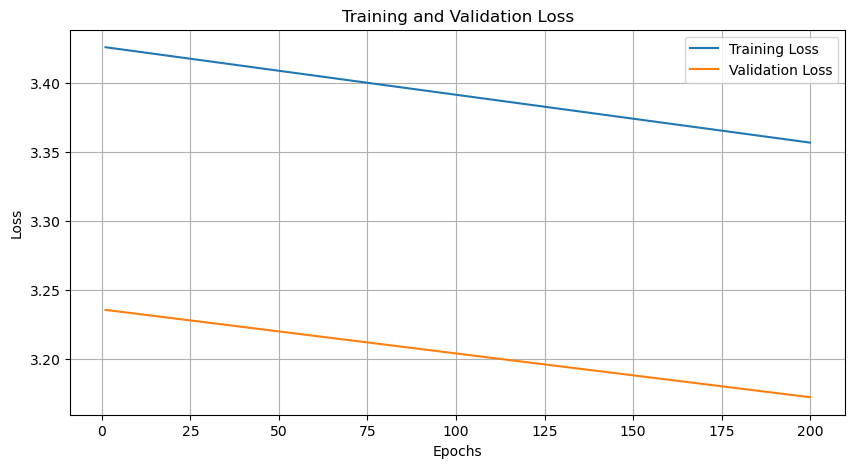

Test Accuracy: 44.58%
Sensitivity (Recall): 0.4284
Specificity: 0.5146
Confusion Matrix:
[[211 199]
 [926 694]]
testing variables 1e-07


  2%|▎         | 5/200 [00:00<00:04, 47.30it/s]

Epoch 1 completed. Train Loss: 3.6505, Val Loss: 3.3346, Val Accuracy: 216330000.00%



 15%|█▌        | 30/200 [00:00<00:03, 47.64it/s]

Epoch 21 completed. Train Loss: 3.6499, Val Loss: 3.3340, Val Accuracy: 216330000.00%



 25%|██▌       | 50/200 [00:01<00:03, 47.63it/s]

Epoch 41 completed. Train Loss: 3.6494, Val Loss: 3.3335, Val Accuracy: 216330000.00%



 35%|███▌      | 70/200 [00:01<00:02, 48.39it/s]

Epoch 61 completed. Train Loss: 3.6488, Val Loss: 3.3330, Val Accuracy: 216330000.00%



 45%|████▌     | 90/200 [00:01<00:02, 46.86it/s]

Epoch 81 completed. Train Loss: 3.6482, Val Loss: 3.3324, Val Accuracy: 216330000.00%



 55%|█████▌    | 110/200 [00:02<00:01, 47.41it/s]

Epoch 101 completed. Train Loss: 3.6476, Val Loss: 3.3319, Val Accuracy: 216330000.00%



 64%|██████▍   | 128/200 [00:02<00:01, 51.16it/s]

Epoch 121 completed. Train Loss: 3.6470, Val Loss: 3.3314, Val Accuracy: 216330000.00%



 73%|███████▎  | 146/200 [00:03<00:01, 50.42it/s]

Epoch 141 completed. Train Loss: 3.6464, Val Loss: 3.3308, Val Accuracy: 216330000.00%



 84%|████████▎ | 167/200 [00:03<00:00, 48.23it/s]

Epoch 161 completed. Train Loss: 3.6459, Val Loss: 3.3303, Val Accuracy: 216330000.00%



 95%|█████████▌| 190/200 [00:03<00:00, 49.00it/s]

Epoch 181 completed. Train Loss: 3.6453, Val Loss: 3.3298, Val Accuracy: 216330000.00%



100%|██████████| 200/200 [00:04<00:00, 48.65it/s]


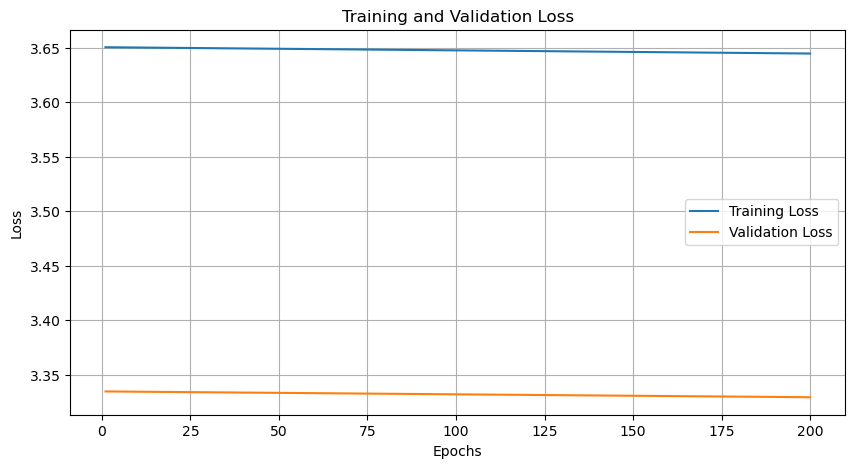

Test Accuracy: 49.06%
Sensitivity (Recall): 0.5130
Specificity: 0.4024
Confusion Matrix:
[[165 245]
 [789 831]]


In [114]:
for _ in [1e-2 ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss000000000000000000000000000000000000000000001e-3, 1e-4]:
    print('=== testing variables', _)
    
    lr = _
    
    model = GCN(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    num_epochs = 200

    train_and_validate(model, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs=num_epochs)

## cache

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Assume clinical_lung_features is your input DataFrame and adjacency_matrix is your edge matrix
features = clinical_lung_features.values  # shape (10150, 38)
adjacency_matrix = adjacency_matrix  # shape (10150, 10150)

# Assume y is your labels column in the dataframe
y = clinical_lung_labels  # Replace this with your actual labels (shape: 10150,)

# Step 1: Perform stratified split into train+val and test sets
train_val_indices, test_indices = train_test_split(
    np.arange(features.shape[0]),
    test_size=0.2,
    random_state=42,
    stratify=y  # Ensure that the split is stratified based on the labels
)

# Step 2: Further split the train+val set into separate training and validation sets
train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=0.25,  # 25% of train+val becomes the validation set, so 0.25 * 0.8 = 0.2 of the total data
    random_state=42,
    stratify=y.iloc[train_val_indices]  # Stratify based on the labels in the train+val set
)

# Separate features and labels based on the indices
train_features = torch.tensor(features[train_indices], dtype=torch.float32)
val_features = torch.tensor(features[val_indices], dtype=torch.float32)
test_features = torch.tensor(features[test_indices], dtype=torch.float32)

train_labels = torch.tensor(y.iloc[train_indices].values, dtype=torch.float16)
val_labels = torch.tensor(y.iloc[val_indices].values, dtype=torch.float16)
test_labels = torch.tensor(y.iloc[test_indices].values, dtype=torch.float16)

# Train adjacency matrix (rows and columns of the train_indices
# Train, val, and test indices (these would be your node splits)
train_indices = train_indices
val_indices = val_indices
test_indices = test_indices

# Step 1: Create sets of indices for quick lookup
train_set = set(train_indices)
val_set = set(val_indices)
test_set = set(test_indices)

# Step 2: Function to filter edges for specific index set
def filter_edges_by_node_split(edge_index, node_set):
    mask = [(src in node_set) and (dst in node_set) for src, dst in zip(edge_index[0], edge_index[1])]
    filtered_edge_index = edge_index[:, mask]
    return filtered_edge_index

# Step 3: Filter edges for train, validation, and test
train_edge_index = filter_edges_by_node_split(edge_index_tensor, train_indices)
val_edge_index = filter_edges_by_node_split(edge_index_tensor, val_indices)
test_edge_index = filter_edges_by_node_split(edge_index_tensor, test_indices)

# Now you can use these for respective splits
print("Train Edge Index:", train_edge_index)
print("Validation Edge Index:", val_edge_index)
print("Test Edge Index:", test_edge_index)

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader, loader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np

# Assume clinical_lung_features is your input DataFrame and adjacency_matrix is your edge matrix

# Step 1: Convert DataFrame (features) and adjacency matrix into PyTorch tensors
features = torch.tensor(clinical_lung_features.values, dtype=torch.float32)  # shape (10150, 38)
adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)  # shape (10150, 10150)

# Create edge_index from adjacency matrix
def adjacency_to_edge_index(adj_matrix):
    edge_index = []
    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            if adj_matrix[i, j] != 0:  # If there's an edge
                edge_index.append([i, j])
    return torch.tensor(edge_index).t().contiguous()  # Transpose to match PyG's format

edge_index = adjacency_to_edge_index(adjacency_matrix)

In [8]:


# Step 2: Create a PyTorch Geometric Data object
data = Data(x=features, edge_index=edge_index)


In [13]:

# Step 3: Create a DataLoader for batching
batch_size = 64  # You can adjust this as needed
loader = DataLoader([data], batch_size=batch_size, shuffle=True)


In [14]:
# Step 4: Define the GCN Model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # First GCN layer with ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Second GCN layer
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
# Step 5: Instantiate the model, loss function, and optimizer
input_dim = features.shape[1]  # 38 features in the input
hidden_dim = 64  # Arbitrary hidden layer size, adjust as needed
output_dim = 2  # Number of output classes, adjust based on your problem

model = GCN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Step 6: Training Loop
def train():
    model.train()
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch)
        # Assume you have labels (use the appropriate labels here)
        loss = criterion(out, batch.y)  # You need to provide actual labels for batch.y
        loss.backward()
        optimizer.step()
        print(f"Training loss: {loss.item()}")

# To run the training function
train()
